In [1]:
#%%

import os
import numpy as np
import matplotlib.pyplot as plt
from seaborn import cubehelix_palette, heatmap
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
import deeplay as dl
import torchmetrics as tm

In [2]:
#%% Load MNIST data

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

train_path = os.path.join("MNIST_dataset", "mnist", "train")
train_image_files = sorted(os.listdir(train_path))
test_path = os.path.join("MNIST_dataset", "mnist", "test")
test_image_files = sorted(os.listdir(test_path))

In [3]:
#%% Dataset with one-hot encoding

class MNISTOneHotDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.num_classes = 10  # MNIST has 10 classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        # Convert label to one-hot encoding
        one_hot_label = torch.nn.functional.one_hot(torch.tensor(label, dtype=torch.long), num_classes=self.num_classes).float()
        
        return image, one_hot_label

transform = Compose([ToTensor()])

# Prepare training data
train_images = [plt.imread(os.path.join(train_path, file)) for file in train_image_files] #List of numpy array
train_digits = [int(os.path.basename(file)[0]) for file in train_image_files]
train_dataset = MNISTOneHotDataset(train_images, train_digits, transform=transform) #Makes into dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #

# Prepare test data
test_images = [plt.imread(os.path.join(test_path, file)) for file in test_image_files]
test_digits = [int(os.path.basename(file)[0]) for file in test_image_files]
test_dataset = MNISTOneHotDataset(test_images, test_digits, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


conv_base = dl.ConvolutionalNeuralNetwork(
    in_channels=1,
    hidden_channels=[16, 16, 32],
    out_channels=32,
)
conv_base.blocks[2].pool.configure(torch.nn.MaxPool2d, kernel_size=2)

connector = dl.Layer(torch.nn.AdaptiveAvgPool2d, output_size=1)

dense_top = dl.MultiLayerPerceptron(
    in_features=32,
    hidden_features=[],
    out_features=10,
    out_activation=torch.nn.Softmax(dim=1), 
)

cnn = dl.Sequential(conv_base, connector, dense_top)

# Using categorical crossentropy loss since Softmax activation
cnn_classifier = dl.Classifier(
    model=cnn,
    optimizer=dl.RMSprop(lr=0.001),
    metrics=[tm.Accuracy(task="multilabel", num_labels=10)],
).create()

In [4]:
#%% Training

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # If cuda available
print(f"Using device: {device}")

# Move your model to the GPU
cnn_classifier = cnn_classifier.to(device)

cnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto", devices = "auto")
cnn_trainer.fit(cnn_classifier, train_loader)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_m

Using device: cuda
Epoch 4: 100%|██████████| 1875/1875 [00:15<00:00, 124.75it/s, v_num=39, train_loss_step=1.490, trainMultilabelAccuracy_step=0.994, train_loss_epoch=1.530, trainMultilabelAccuracy_epoch=0.988]


In [5]:
#%% Test

test_results = cnn_trainer.test(cnn_classifier, test_loader)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 160.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMultilabelAccuracy_epoch │      0.9900799989700317      │
│       test_loss_epoch        │      1.5130733251571655      │
└──────────────────────────────┴──────────────────────────────┘

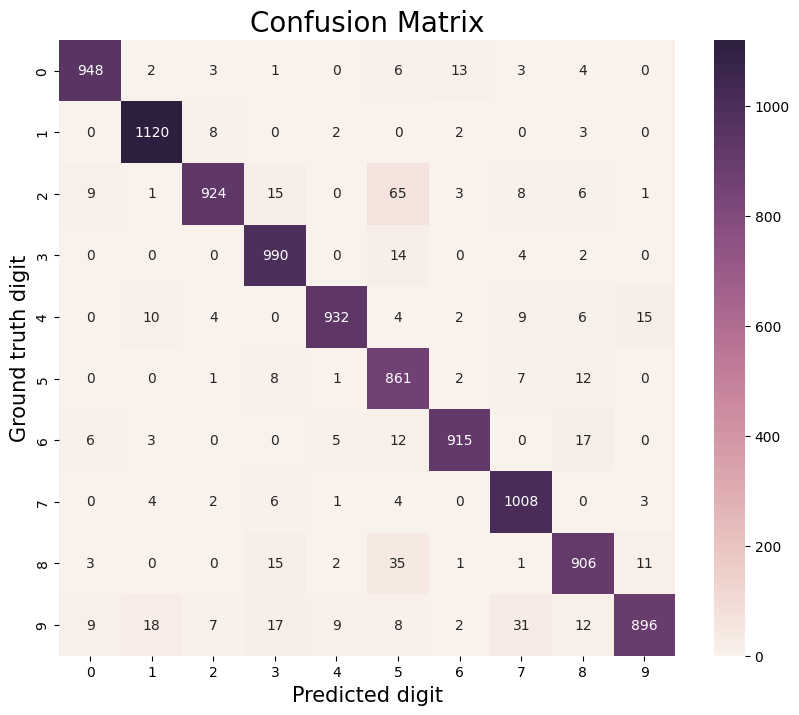

In [6]:
#%% Confusion Matrix

def plot_confusion_matrix(classifier, dataloader, device='cpu'):
    confusion_matrix = np.zeros((10, 10), dtype=int)
    
    # Set model to evaluation mode
    classifier.eval()
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            # Move data to device
            images = images.to(device)
            
            predictions = classifier.model(images)  # Access the underlying model
                
            gt_digits = torch.argmax(labels, dim=1)
                
            # Get predicted class indices
            pred_digits = torch.argmax(predictions, dim=1)
            
            # Update confusion matrix
            for gt, pred in zip(gt_digits.cpu().numpy(), pred_digits.cpu().numpy()):
                confusion_matrix[gt, pred] += 1

    plt.figure(figsize=(10, 8))
    heatmap(confusion_matrix, annot=True, fmt="d", square=True,
            cmap=cubehelix_palette(light=0.95, as_cmap=True), 
            xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted digit", fontsize=15)
    plt.ylabel("Ground truth digit", fontsize=15)
    plt.title("Confusion Matrix", fontsize=20)
    plt.show()

# Usage example:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_classifier = cnn_classifier.to(device)  # Move model to device
plot_confusion_matrix(cnn_classifier, test_loader, device=device)